### STARRED deconvolution algorithm aplication for some images

In [2]:
# Packages used
import numpy as np
from astropy.io import fits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
import glob
import os
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import colors
import pyregion
import cupy as cp


# PYTHONPHOT
import PythonPhot as pp

# STARRED

from starred.psf.psf import PSF
from starred.psf.loss import Loss
from starred.optim.optimization import Optimizer
from starred.psf.parameters import ParametersPSF
from starred.plots import plot_function as pltf
from starred.utils.generic_utils import save_fits
from starred.utils import ds9reg
from starred.utils.noise_utils import propagate_noise
from starred.plots import plot_function as pltf
from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.plots.plot_function import plot_deconvolution, view_deconv_model


from astropy.nddata.utils import Cutout2D


#### FUNCTIONS DEFINITION

In [3]:
# Open the images of interest
def get_images(image_paths):
    open_images = np.array([fits.open(p) for p in image_paths])
    headers = [o[0].header for o in open_images]
    images = np.array([o[0].data for o in open_images])
    Nimage=len(image_paths)
    return open_images, images, Nimage, headers

In [4]:
# Prameters from header
def header_param(headers):
    readnoises = np.array([headers[i]['RDNOISE'] for i in range(len(headers))])
    fwhms = np.array([headers[i]["FWHM"] for i in range(len(headers))])
    w_images = np.array([wcs.WCS(headers[i]) for i in range(len(headers))])
    return readnoises, fwhms, w_images

In [5]:
# Transform the RA DEC coordinates to XY coordinates
def radec_to_xy(target_radec, w_images):
    c = SkyCoord(target_radec[0], target_radec[1], frame='icrs')
    x = np.array([w.all_world2pix(c.ra,c.dec, 1, quiet=True)[0] for w in w_images])
    y = np.array([w.all_world2pix(c.ra,c.dec, 1, quiet=True)[1] for w in w_images])
    return x, y

In [6]:
# Cut the images
def crop_images(image, x, y, size, w, header):
    cut = Cutout2D(image, (x,y), (size,size), wcs=w)
    cut_image = cut.data
    cut_wcs = cut.wcs
    header.update(cut_wcs.to_header(relax=True))
    return cut_image

In [7]:
# Plot of the images cropped
def plot_crop_images(Nimage, crops, xgls, ygls):
    figure, axis = plt.subplots(Nimage, len(crops), figsize=(10, 10))
    for i in range(Nimage):
        for j in range(len(crops)):
            axis[i][j].imshow(crops[j][i], cmap='gray', vmin=200, vmax=1000, origin= 'lower')
        axis[i][0].set_title("Ephoc "+str(i+1))
    plt.tight_layout()

In [8]:
# Find stars in the images using Pythonphot
def find_stars(Nimage, images, readnoises, fwhms):
    xstars = []
    ystars = []   
    for i in range(Nimage):   
        skymod, skysig, skyskw = pp.mmm.mmm(images[i],readnoise=readnoises[i])
        hmin = skysig*5
        print(hmin)
        xstar, ystar, flux, sharp, roundness = pp.find.find(images[i],hmin,fwhms[i])
        xstars.append(xstar)
        ystars.append(ystar)
    return xstars,ystars

In [9]:
# Plot the images pointing the stars
def plot_find_stars(Nimage, images, xstars, ystars, readnoises):
    figure, axis = plt.subplots(1, Nimage, figsize=(20, 20))
    for i in range(Nimage):
        axis[i].imshow(images[i], cmap='gray', vmin=200, vmax=1000, origin= 'lower')
        axis[i].plot(xstars[i], ystars[i],'o', ms=10, mfc='none', lw=2, mec='r')
        axis[i].set_title("Ephoc " + str(i+1))
    plt.tight_layout()

In [10]:
# Find the stars near the target
def stars_near_target(Nimage, image, xstars, ystars, xgls, ygls, sizeexcl):
    stars_position_ords = []
    stars_sky_ords = []
    bright_ords = []
    for i in range(Nimage):
        excl = int(np.shape(image[i])[1]/2)
        # Stars position excluding the target
        stars_position=np.array([(x,y) for x,y in zip(xstars[i],ystars[i])  if not ((excl-sizeexcl<x<excl+sizeexcl) and (excl-sizeexcl<y<excl+sizeexcl))])
        # Cutout of the stars excluding the target
        stars_sky=[image[i][int(np.round(y)-20):int(np.round(y)+20),int(np.round(x)-20):int(np.round(x)+20)] for x,y in zip(xstars[i],ystars[i]) if not ((excl-sizeexcl<x<excl+sizeexcl) and (excl-sizeexcl<y<excl+sizeexcl))]
        
        # Max bright of the cutouts to organize the stars in function its bright
        bright=np.array([stars_sky[i].max() if len(stars_sky[i])!=0 else 0 for i in range(len(stars_sky))])
        
        # Organization
        bright_ord=np.array(np.sort(bright))
        stars_sky_ord=[stars_sky[list(bright).index(i)] for i in np.sort(bright)]
        stars_position_ord=np.array([stars_position[list(bright).index(i)] for i in np.sort(bright)])
        print("There are", len(stars_position_ord), "stars near the target")
        stars_position_ords.append(stars_position_ord)
        stars_sky_ords.append(stars_sky_ord)
        bright_ords.append(bright_ord)
        
    return stars_position_ords, stars_sky_ords, bright_ords

In [11]:
# Plot the stars near the target
def plot_near_stars(Nimage, stars_sky_ords, numstarsplot):
    figure, axis = plt.subplots(Nimage, numstarsplot, figsize=(20, 20))
    for i in range(Nimage):
        for j in range(1,numstarsplot+1):
            axis[i][j-1].imshow(stars_sky_ords[i][-j], cmap='gray', vmin=200, vmax=1000, origin= 'lower')
            axis[i][j-1].set_title('Star index ' + str(-j))
        axis[i][0].set_title("Ephoc "+str(i+1) + ' Star index ' + str(-1))
        plt.tight_layout()

In [12]:
# Plot stars used to make the narrow PSF in the image
def plot_image_with_stars_psf(Nimage, image, stars_position_psfs):
    # Plot the images and the stars choosed
    print(Nimage)
    figure, axis = plt.subplots(1, Nimage, figsize=(20, 20))    
    for i in range(Nimage):    
        xpsf=[]
        ypsf=[]
        for j in range(len(stars_position_psfs[i])):
            xpsf.append(stars_position_psfs[i][j][0])
            ypsf.append(stars_position_psfs[i][j][1])
        axis[i].imshow(image[i], cmap='gray', vmin=200, vmax=1000, origin= 'lower') 
        axis[i].plot(xpsf,ypsf,'o',ms=10,mfc='none',lw=2,mec='r')


    plt.tight_layout() 

In [13]:
# Plot stars used to make the narrow PSF
def plot_stars_psf(Nimage, stars_sky_psfs):
    figure, axis = plt.subplots(Nimage, len(stars_sky_psfs[0]), figsize=(20, 20))
    for i in range(Nimage):
        for j in range(len(stars_sky_psfs[i])):
            axis[i][j].imshow(stars_sky_psfs[i][j], cmap='gray', vmin=200, vmax=1000, origin= 'lower')
        axis[i][0].set_title("Stars used to make the narrow PSF, ephoc " + str(i+1))
    plt.tight_layout() 

In [14]:
# Parameters for the PSF
def param_for_psf(stars_sky_psfs, subsampling_factor = 2):
    # Some parameters
    #subsampling_factor = subsampling_factor
    Nep=len(stars_sky_psfs)
    Nstars=len(stars_sky_psfs[0])
    image_size = np.shape(stars_sky_psfs[0])[1] # data dimensions
    image_size_up = image_size * subsampling_factor 
    print(Nep, Nstars, image_size, image_size_up)
    return subsampling_factor, Nep, Nstars, image_size, image_size_up

In [15]:
# Make the noise map of the stars used to build the PSF
def noise_map_stars(Nep, Nstars, image_size, stars_sky_psfs):
    sigma_2 = np.zeros((Nep, Nstars, image_size, image_size))
    # Standard deviation of some background pixels
    sigma_sky_2 = np.array([[np.std(stars_sky_psfs[i][j][int(0.9*image_size):,int(0.9*image_size):]) for j in range(Nstars)] for i in range(Nep)]) ** 2
    for i in range(Nep):
        for j in range(Nstars):
            sigma_2[i][j][:,:] = sigma_sky_2[i][j] + stars_sky_psfs[i][j][:,:].clip(min=0) 
        norm = stars_sky_psfs[i][0].max() / 100.
        stars_sky_psfs[i] /= norm
        sigma_2[i] /= norm**2
    return sigma_2

In [16]:
# Plot the noise maps
def plot_stars_noisemaps(Nep, Nstars, stars_sky_psfs, sigma_2):
    for i in range(Nep):
        fig = pltf.display_data(stars_sky_psfs[i], sigma_2[i], units='e-')

In [17]:
# Build the PSF model
def model_psf(Nep, Nstars, image_size, subsampling_factor, convolution_method = 'scipy', include_moffat = True, elliptical = True):
    model = np.array([PSF(image_size=image_size, number_of_sources=Nstars, 
            upsampling_factor=subsampling_factor, 
            convolution_method=convolution_method,
            include_moffat=include_moffat,
            elliptical_moffat=elliptical) for i in range(Nep)])
    return model

In [18]:
# Parameter initialization.
def model_param_inicialization(Nep, model, stars_sky_psfs):
    kwargs_init = []
    kwargs_fixed = []
    kwargs_up = []
    kwargs_down = []
    for i in range(Nep):
        kwargs_init0, kwargs_fixed0, kwargs_up0, kwargs_down0 = model[i].smart_guess(stars_sky_psfs[i], fixed_background=True)
        kwargs_init.append(kwargs_init0)
        kwargs_fixed.append(kwargs_fixed0)
        kwargs_up.append(kwargs_up0)
        kwargs_down.append(kwargs_down0)
    kwargs_init = np.array(kwargs_init)
    kwargs_fixed = np.array(kwargs_fixed)
    kwargs_up = np.array(kwargs_up)
    kwargs_down = np.array(kwargs_down)
    return  kwargs_init, kwargs_fixed, kwargs_up, kwargs_down

In [19]:
def optimization(Nep, stars_sky_psfs, model, parameters, sigma_2, Nstars):
    optim_method = 'Newton-CG'
    optimiser_options = {'maxiter':20, 'restart_from_init':True}
    loss = []
    optim = []
    best_fit = []
    logL_best_fit = []
    extra_fields = []
    runtime = []
    for i in range(Nep):
        loss0 = Loss(stars_sky_psfs[0], model[0], parameters[0], sigma_2[0], Nstars, regularization_terms='l1_starlet', 
                regularization_strength_scales=0, regularization_strength_hf=0, masks =None)
        loss.append(loss0)
        optim0 = Optimizer(loss0, parameters[i], method=optim_method)
        optim.append(optim0)
        best_fit0, logL_best_fit0, extra_fields0, runtime0 = optim0.minimize(**optimiser_options)
        best_fit.append(best_fit0)
        logL_best_fit.append(logL_best_fit0)
        extra_fields.append(extra_fields0)
        runtime.append(runtime0)
    loss = np.array(loss)
    optim = np.array(optim)
    best_fit = np.array(best_fit)
    logL_best_fit = np.array(logL_best_fit)
    extra_fields = np.array(extra_fields)
    runtime = np.array(runtime)
    return loss, optim, best_fit, logL_best_fit, extra_fields, runtime

In [20]:
def optimization2(Nep, stars_sky_psfs, model, parameters, sigma_2, Nstars):
    optimiser_options = {'maxiter':20, 'restart_from_init':True}
    loss = []
    optim = []
    best_fit = []
    logL_best_fit = []
    extra_fields = []
    runtime = []
    for i in range(Nep):
        loss0 = Loss(stars_sky_psfs[0], model[0], parameters[0], sigma_2[0], Nstars, regularization_terms='l1_starlet', 
                regularization_strength_scales=0, regularization_strength_hf=0, masks =None)
        loss.append(loss0)
        optim0 = Optimizer(loss0, parameters[i], method='adabelief')
        optim.append(optim0)
        best_fit0, logL_best_fit0, extra_fields0, runtime0 = optim0.minimize(max_iterations=250)
        best_fit.append(best_fit0)
        logL_best_fit.append(logL_best_fit0)
        extra_fields.append(extra_fields0)
        runtime.append(runtime0)
    loss = np.array(loss)
    optim = np.array(optim)
    best_fit = np.array(best_fit)
    logL_best_fit = np.array(logL_best_fit)
    extra_fields = np.array(extra_fields)
    runtime = np.array(runtime)
    return loss, optim, best_fit, logL_best_fit, extra_fields, runtime

#### _____________________________________________________________________________________________________________________________________________________________________________________________

In [21]:
# Write the paths of the images that you want to deconvolve and the ra dec of the target
image_paths = ["work/red/2023-10-17/TTT1_iKon936-1_2023-10-17-22-02-05-804423_Q2237+030.fits"]#, "work/red/2023-10-17/TTT1_iKon936-1_2023-10-17-22-11-33-272303_Q2237+030.fits", \
         #"work/red/2023-10-17/TTT1_iKon936-1_2023-10-17-22-16-40-389385_Q2237+030.fits", "work/red/2023-10-17/TTT1_iKon936-1_2023-10-17-22-25-49-277266_Q2237+030.fits"]
target_radec = np.array(['22h40m30.23447s', '+3d21m30.6290s'])

In [22]:
c = SkyCoord(target_radec[0], target_radec[1], frame='icrs')

In [23]:
open_images, images, Nimage, headers = get_images(image_paths)
print(headers[0])

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  IMAGETYP= 'SCIENCE '           / Type of image                                  COMMENT ***************************                                             COMMENT          TELESCOPE                                                      COMMENT ***************************                                             TELESCOP= 'TTT1    '           / Telescope name                                 SITENAME= 'Teide Observatory (IAC)' / Telescope site name                       SITECODE= 'Y65     '           / Telescope IAU Code                             SITELAT =          28.29871121 / [deg] T

In [87]:
readnoises, fwhms, w_images = header_param(headers)
xgls, ygls = radec_to_xy(target_radec, w_images)

In [88]:
# Define the size of the crops and crop the images
# images1000 = np.empty((Nimage, 1000, 1000))
images600 = np.empty((Nimage, 600, 600))
# images200 = np.empty((Nimage, 200, 200))
images40 = np.empty((Nimage, 40, 40))
for i in range(Nimage):
    # images1000[i] = crop_images(images[i], xgls[i], ygls[i], np.shape(images1000)[1], w_images[i], headers[i])
    # images200[i] = crop_images(images[i], xgls[i], ygls[i], np.shape(images200)[1], w_images[i], headers[i])
    images600[i] = crop_images(images[i], xgls[i], ygls[i], np.shape(images600)[1], w_images[i], headers[i])
    images40[i] = crop_images(images[i], xgls[i], ygls[i], np.shape(images40)[1], w_images[i], headers[i])
#crops = [images600, images40]

In [89]:
readnoises, fwhms, w_images = header_param(headers)
xgls, ygls = radec_to_xy(target_radec, w_images)

In [90]:
plot_crop_images(Nimage, crops, xgls, ygls)

NameError: name 'crops' is not defined

In [91]:
xstars, ystars = find_stars(Nimage, images600, readnoises, fwhms)

46.67591649824864
Input Image Size is 600 by 600
RELATIVE ERROR computed from FWHM 0.8218495424390727
Beginning convolution of image
Finished convolution of image
28 local maxima located above threshold
     STAR      X      Y     FLUX     SHARP    ROUND
 No. of sources rejected by SHARPNESS criteria 0
 No. of sources rejected by ROUNDNESS criteria 1
 No. of sources rejected by CENTROID  criteria 1


In [92]:
#plot_find_stars(Nimage, images600, xstars, ystars, readnoises)

In [93]:
stars_position_ords, stars_sky_ords, bright_ords = stars_near_target(Nimage, images600, xstars, ystars, xgls, ygls, sizeexcl = 50)

There are 23 stars near the target


In [94]:
# Plot the stars that are near the target from the brightest to the least bright to choose which stars will be used to build the PSF
#plot_near_stars(Nimage, stars_sky_ords, numstarsplot=10)

In [95]:
# def choose_stars(Nimage):
#     numstars = int(input('How many stars do you want to use to generate the narrow PSF? ' ))
#     yesno = input('Do you want to use the same stars for the ' + str(Nimage) + ' images? (yes/no)' )
#     while yesno not in ("yes", "no"):
#         print('You have to asnwer with yes or no!')
#         yesno = input('Do you want to use the same stars for the ' + str(Nimage) + ' images? (yes/no)' )
#     if yesno == 'yes':
#         for j in range(numstars):
#                 star = int(input('Star index ' + str(j+1) + ' of the images:' ))
           
#     else:
#         samestars=int(input('How many images will have the same stars? '))
#         while samestars not in range(Nimage+1):
#             print('It is impossible for the number of images that share the same stars not to be between 0 and ' + str(Nimage) + '.')
#             samestars=int(input('How many images will have the same stars? '))
#         numsame = []
#         for h in range(0, Nimage+1):
#             numsame.append(h)
#         if samestars == 0:
#             for i in range(Nimage):
#                 for j in range(numstars):
#                     star = int(input('Star index ' + str(j+1) + ' of the image ' + str(i+1) + ':' ))
#         sameimages = []
#         else:
#             print('Which images have the same stars? Write the numbers of the images one by one.')
#             for i in range(samestars):
#                 which = int(input())
#                 sameimages.append(which)
                
                

In [96]:
# Write the position of the stars in 'stars_sky_ords' that will be used to build the PSF
# HOW CAN I CHOOSE THE STARS EASILY?!?!
position1 = [-4,-5,-6,-7,-8,-9]
position2 = [-4,-5,-6,-8,-9,-13] 

stars_sky_psfs = []
stars_position_psfs = []
for i in range(Nimage):
    stars_sky_psf = []
    stars_position_psf = []
    if i!=1:
        for j in position1:
            stars_sky_psf.append(stars_sky_ords[i][j])
            stars_position_psf.append(stars_position_ords[i][j])
    else:
        for j in position2:
            stars_sky_psf.append(stars_sky_ords[i][j])
            stars_position_psf.append(stars_position_ords[i][j])
            
    stars_sky_psfs.append(np.array(stars_sky_psf))
    stars_position_psfs.append(np.array(stars_position_psf))

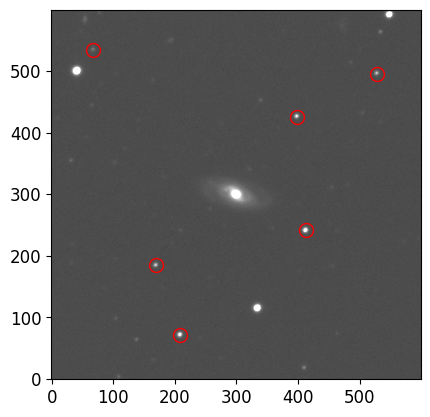

In [103]:
xpsf=[]
ypsf=[]
for j in range(len(stars_position_psfs[i])):
    xpsf.append(stars_position_psfs[i][j][0])
    ypsf.append(stars_position_psfs[i][j][1])
plt.imshow(images600[0], cmap='gray', vmin=200, vmax=1000, origin= 'lower') 
plt.plot(xpsf,ypsf,'o',ms=10,mfc='none',lw=2,mec='r')

[array([[412.13028438, 241.07647663],
       [208.48565836,  71.81294946],
       [397.92988018, 425.89622889],
       [169.25806864, 184.51913753],
       [527.68560657, 495.7213777 ],
       [ 67.54211309, 534.27540126]])]
1


TypeError: 'Axes' object is not subscriptable

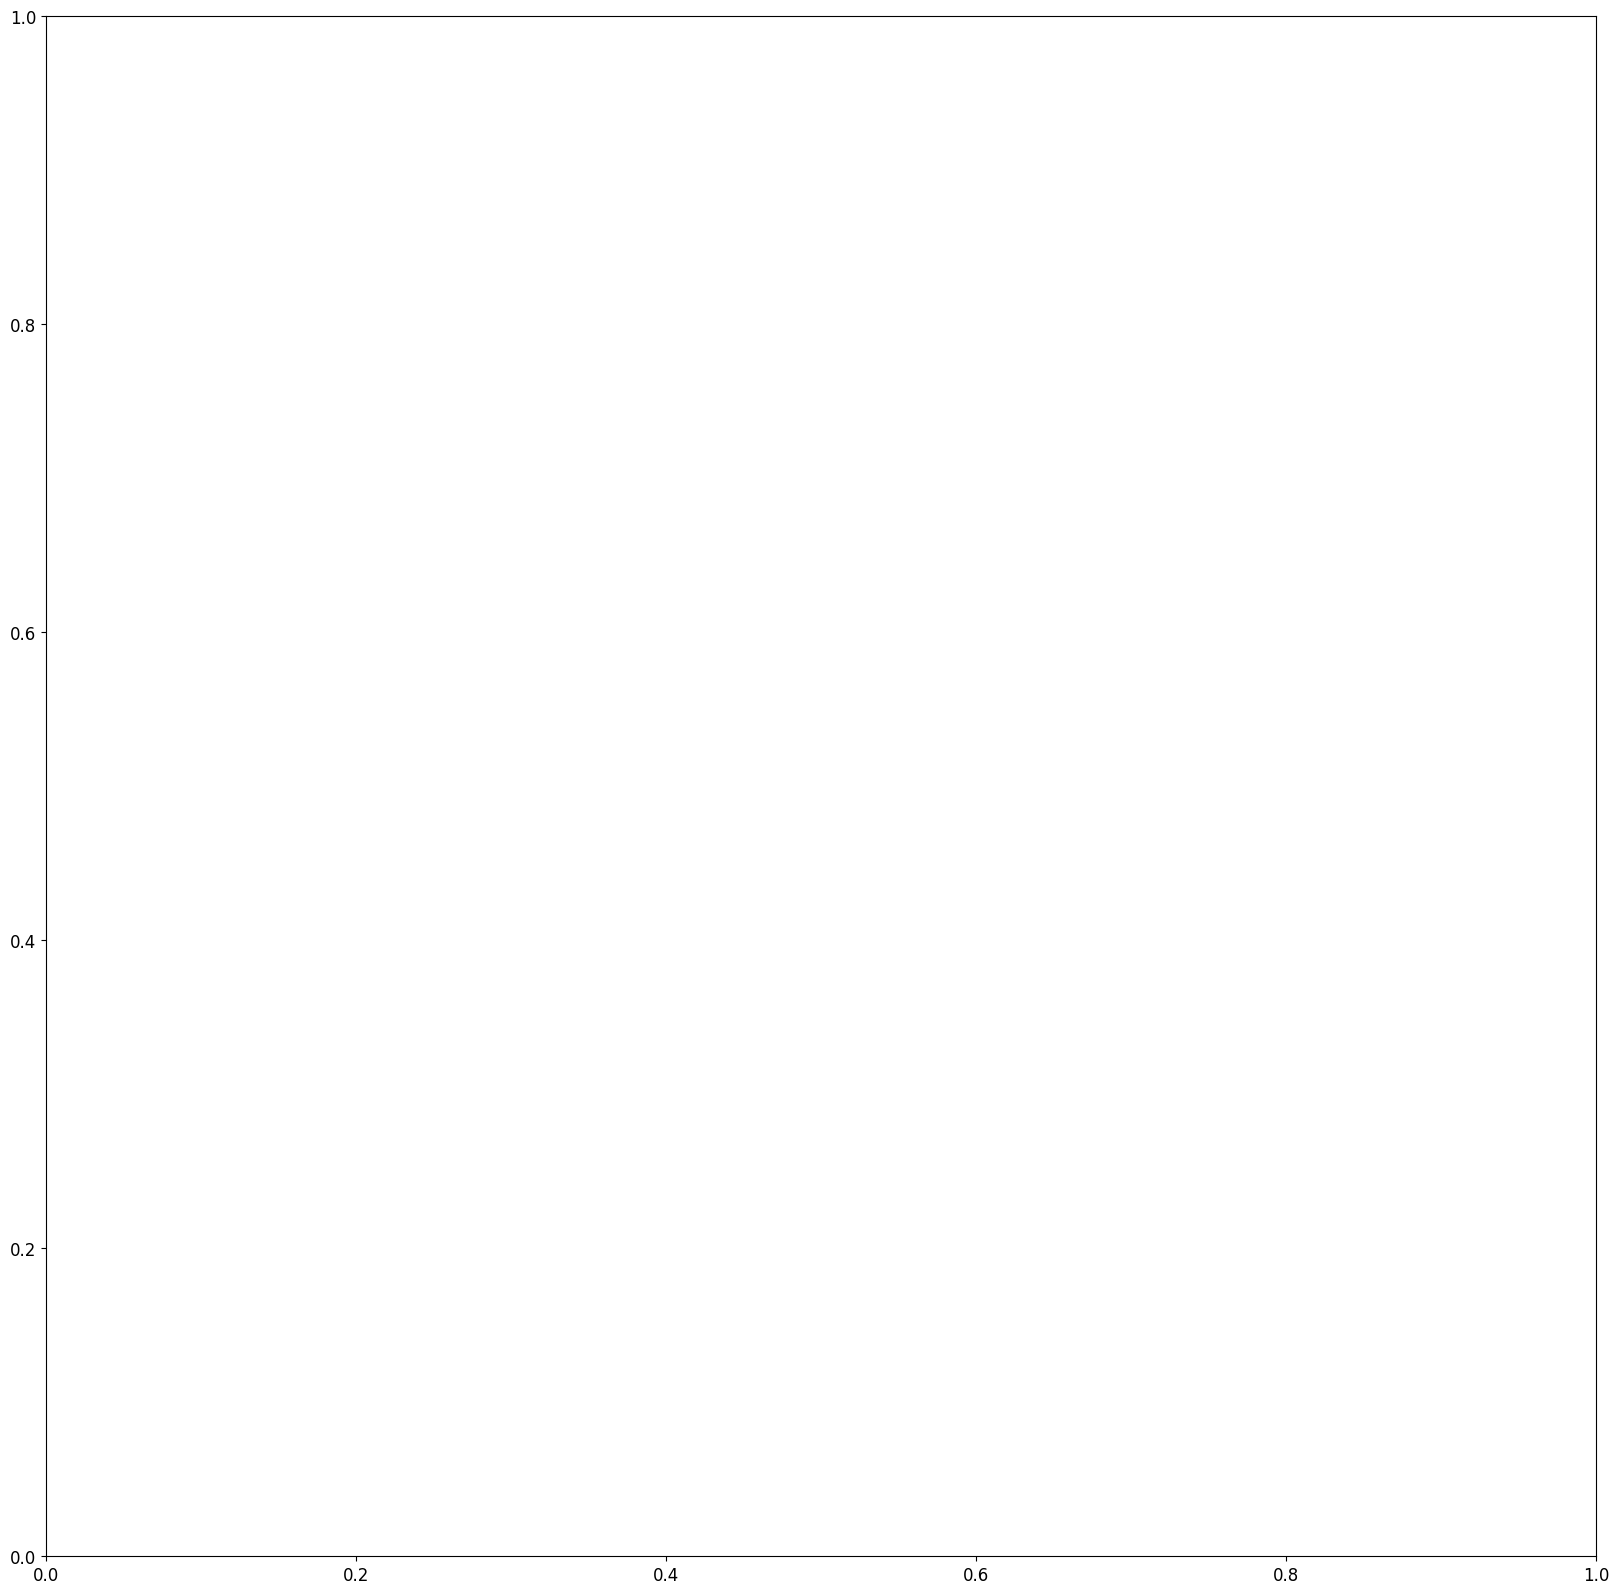

In [100]:
print(stars_position_psfs)
plot_image_with_stars_psf(Nimage, images600, stars_position_psfs)

In [34]:
#plot_stars_psf(Nimage, stars_sky_psfs)

In [35]:
# Parameters for the PSF, it is possible to change the subsampling_factor adding "subsampling_factor=X" in the fuinction, next there is an example ->
# -> subsampling_factor, Nep, Nstars, image_size, image_size_up = param_psf(stars_sky_psfs, subsampling_factor=3)
subsampling_factor, Nep, Nstars, image_size, image_size_up = param_for_psf(stars_sky_psfs)

1 6 40 80


In [36]:
sigma_2 = noise_map_stars(Nep, Nstars, image_size, stars_sky_psfs)

In [37]:
# Plots of the stars and its noise maps taht will be used for computing the narrow psf
# plot_stars_noisemaps(Nep, Nstars, stars_sky_psfs, sigma_2)

In [38]:
# Build the PSF model
model = model_psf(Nep, Nstars, image_size, subsampling_factor) #convolution_method = 'scipy', include_moffat = True, elliptical = True

# Parameter initialization.
kwargs_init, kwargs_fixed, kwargs_up, kwargs_down = model_param_inicialization(Nep, model, stars_sky_psfs)

parameters = np.array([ParametersPSF(kwargs_init[i], kwargs_fixed[i], kwargs_up=kwargs_up[i], kwargs_down=kwargs_down[i]) for i in range(Nep)])

CUDA backend failed to initialize: Found CUDA version 11060, but JAX was built against version 11080, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [39]:
# Optimization
loss, optim, best_fit, logL_best_fit, extra_fields, runtime = optimization(Nep, stars_sky_psfs, model, parameters, sigma_2, Nstars)

/home/alexmunte/starred/optim/optimization.py:78: UserWarning: You are using an unconstrained optimiser. Bounds are ignored.
  warnings.warn('You are using an unconstrained optimiser. Bounds are ignored.')


In [40]:
# Printing partial results
kwargs_partial = np.array([parameters[i].args2kwargs(best_fit[i]) for i in range(Nep)])


In [41]:
#for i in range(Nep):
#    fi = pltf.single_PSF_plot(model[i], stars_sky_psfs[i], sigma_2[i], kwargs_partial[i], n_psf=0, figsize=(10, 8), units='e-')

In [42]:
# Compute noise level in starlet space, also propagate poisson noise
method_noise = 'MC'
W = np.array([propagate_noise(model[i], np.sqrt(sigma_2[i]), kwargs_partial[i], masks =None, wavelet_type_list=['starlet'], method=method_noise, num_samples=500,
             seed=1, likelihood_type='chi2', verbose=False, upsampling_factor=subsampling_factor)[0] for i in range(Nep)])

#This is a representation of your noise level (background + Poisson) in the different starlet scales

# for j in range(Nep):
#     gix, axs = plt.subplots(1, len(W[j]), figsize=(12, 4))
#     for i, l in enumerate(W[j]):
#         axs[i].imshow(l)
#         print(np.mean(l))
#     plt.show()


/home/alexmunte/starred/utils/noise_utils.py:52: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


In [43]:
lambda_scales = 3. 
lambda_hf = 3.
lambda_positivity = 0.
regularize_full_psf = False
# Release backgound, fix the moffat amplitude
kwargs_moffat_fixed = np.array([{'C':kwargs_partial[i]['kwargs_moffat']['C']} for i in range(Nep)])
kwargs_fixed = np.array([{
    'kwargs_moffat': kwargs_moffat_fixed[i],
    'kwargs_gaussian': {},
    'kwargs_background': {},
} for i in range(Nep)])

parameters = np.array([ParametersPSF(kwargs_partial[i], kwargs_fixed[i], kwargs_up[i], kwargs_down[i]) for i in range(Nep)])
#loss = np.array([Loss(stars_sky_psfs[i], model[i], parameters[i], sigma_2[i], Nstars, regularization_terms='l1_starlet',
#            regularization_strength_scales=lambda_scales, regularization_strength_hf=lambda_hf,
#            regularization_strength_positivity=lambda_positivity, W=W[i], regularize_full_psf=regularize_full_psf, masks=None) for i in range(Nep)])

#optim = np.array([Optimizer(loss[i], parameters[i], method='adabelief') for i in range(Nep)])

#best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(max_iterations=250)

# best_fit = np.empty((4,23))
# logL_best_fit = np.empty(4)
# extra_fields = []
# runtime = np.empty(4)

# for i in range(Nep):
#     best_fit0, logL_best_fit0, extra_fields0, runtime0 = optim[i].minimize(max_iterations=250)
#     best_fit[i] = best_fit0
#     logL_best_fit[i] = logL_best_fit0
#     extra_fields.append(extra_fields0)
#     runtime[i] = np.array([runtime0])

# extra_fields = np.array(extra_fields)

#best_fit = np.array([optim[i].minimize(max_iterations=250)[0] for i in range(Nep)])
#logL_best_fit = np.array([optim[i].minimize(max_iterations=250)[1] for i in range(Nep)])
#extra_fields = np.array([optim[i].minimize(max_iterations=250)[2] for i in range(Nep)])
#runtime = np.array([optim[i].minimize(max_iterations=250)[3] for i in range(Nep)])

loss, optim, best_fit, logL_best_fit, extra_fields, runtime = optimization2(Nep, stars_sky_psfs, model, parameters, sigma_2, Nstars)

optax.adabelief: 100%|██████████| 250/250 [00:02<00:00, 110.49it/s]


In [44]:
# for i in range(Nep):
#     fig_loss = pltf.plot_loss(extra_fields[i]['loss_history'])

kwargs_final = np.array([parameters[i].args2kwargs(best_fit[i]) for i in range(Nep)])


In [45]:
# Example on how to retrieve different elements of the PSF 
n_psf = 0
estimated_full_psf0 = np.array([model[i].model(n_psf, **kwargs_final[i]) for i in range(Nep)])
analytic = np.array([model[i].get_moffat(kwargs_final[i]['kwargs_moffat'], norm=True) for i in range(Nep)])
s = np.array([model[i].get_narrow_psf(**kwargs_final[i], norm=True) for i in range(Nep)])
background = np.array([model[i].get_background(kwargs_final[i]['kwargs_background']) for i in range(Nep)])

full_psf =  np.array([model[i].get_full_psf(**kwargs_final[i]) for i in range(Nep)])

for i in range(Nep):
    print('Overall Reduced Chi2 ' + str(i+1) +  ': ', -2 * loss[i]._log_likelihood_chi2(kwargs_final[i]) / (image_size**2))

Overall Reduced Chi2 1:  18.199165


In [46]:
#for i in range(Nep):
    
#    fig = pltf.single_PSF_plot(model[i], stars_sky_psfs[i], sigma_2[i], kwargs_final[i], n_psf=0, figsize=(12, 8 ), units='e-')

In [47]:
# Plot the PSF and residual from each star
#for i in range(Nep):   
#    fig3 = pltf.multiple_PSF_plot(model[i], stars_sky_psfs[i], sigma_2[i], kwargs_final[i], masks=None, figsize=(12, 8 ), units='e-')

In [48]:
# Astrometry and photometry of the stars used to built the PSF
norm = np.array([stars_sky_psfs[i][0].max() / 100. for i in range(Nep)])
astrometry = np.array([model[i].get_astrometry(**kwargs_final[i]) for i in range(Nep)])
photometry = np.array([model[i].get_photometry(**kwargs_final[i]) * norm[i] for i in range(Nep)])
photometry_highres = np.array([model[i].get_photometry(**kwargs_final[i], high_res=True) * norm[i] / subsampling_factor**2 for i in range(Nep)])# photometry on the subsampled PSF

#for i in range(Nep): 
    #print('Epoch ' + str(i+1))
    #print('Astrometry :', np.asarray(astrometry[i]))
    #print('Photometry :', np.asarray(photometry[i]))
    #print('Photometry high resolution :', np.asarray(photometry_highres[i]))


In [49]:
# save the obtained narrow PSF
output_folder = 'starred/EINSTEINCROSS/3.0'

for i in range(Nep):
    
    file_name = output_folder + '/epoch_' + str(i+1)
    
    if os.path.exists(file_name):
        model[i].export(file_name, kwargs_final[i], stars_sky_psfs[i], sigma_2[i], format='fits')
        model[i].dump(os.path.join(file_name, 'model_einstein_cross.pkl'), kwargs_final[i], norm[i]) 
    else:
        os.mkdir(file_name)
        model[i].export(file_name, kwargs_final[i], stars_sky_psfs[i], sigma_2[i], format='fits')
        model[i].dump(os.path.join(file_name, 'model_einstein_cross.pkl'), kwargs_final[i], norm[i]) 

In [50]:
29.69+0.528


30.218

In [51]:
# Positions of the target and the components from the target 
galaxy_radec = np.array(['340d07m33.51705s', '+3d21m30.6290s'])
a_radec = np.array(['340d07m33.59205s', '+3d21m29.69s'])
b_radec = np.array(['340d07m32.91905', '+3d21m31.387s'])
c_radec = np.array(['340d07m34.22705s', '+3d21m30.899s'])
d_radec = np.array(['340d07m32.72605s', '+3d21m30.218s'])
xgalaxy, ygalaxy = radec_to_xy(galaxy_radec, w_images)
xa, ya = radec_to_xy(a_radec, w_images)
xb, yb = radec_to_xy(b_radec, w_images)
xc, yc = radec_to_xy(c_radec, w_images)
xd, yd = radec_to_xy(d_radec, w_images)
c = SkyCoord(galaxy_radec[0], galaxy_radec[1], frame='icrs')
print(c.ra,c.dec)

340d07m33.51705s 3d21m30.629s


In [52]:
# # Positions of the target and the components from the target 
# galaxy_radec = np.array(['22h40m30.23447s', '+3d21m30.6290s'])
# a_radec = np.array(['22h40m30.34s', '+3d21m28.8s'])
# b_radec = np.array(['22h40m30.30s', '+3d21m30.5s'])
# c_radec = np.array(['22h40m30.38s', '+3d21m30s'])
# d_radec = np.array(['22h40m30.28s', '+3d21m29.3s'])

# xgalaxy, ygalaxy = radec_to_xy(galaxy_radec, w_images)
# c = SkyCoord(galaxy_radec[0], galaxy_radec[1], frame='icrs')
# print(c.ra,c.dec) #340.1259769583 3.3585080556
# xa, ya = radec_to_xy(a_radec, w_images)
# xb, yb = radec_to_xy(b_radec, w_images)
# xc, yc = radec_to_xy(c_radec, w_images)
# xd, yd = radec_to_xy(d_radec, w_images)
# print(xgalaxy, ygalaxy)
# print(xa,ya)
# print(xb,yb)
# print(xc,yc)
# print(xd,yd)

In [53]:
# Transform the RA DEC coordinates to XY coordinates #0.00027777777
def radec_to_xy(target_radec, w_images):
    c = SkyCoord(target_radec[0], target_radec[1], frame='icrs', unit='deg')
    xgls = np.array([w.all_world2pix(c.ra,c.dec, 1, quiet=True)[0] for w in w_images])
    ygls = np.array([w.all_world2pix(c.ra,c.dec, 1, quiet=True)[1] for w in w_images])
    return xgls, ygls

In [54]:
from astropy import units as u
n=(0.95/3600)
c = SkyCoord(a_radec[0], a_radec[1], frame='icrs')
xa2, ya2 = radec_to_xy(np.array(['%s' %(c.ra - n * u.deg), '%s' %(c.dec + n * u.deg)]), w_images)
print(xa2,ya2)
print(np.sqrt(abs(xa2-xa)**2+abs(ya2-ya)**2))

c = SkyCoord(b_radec[0], b_radec[1], frame='icrs')
xb2, yb2 = radec_to_xy(np.array(['%s' %(c.ra + n * u.deg), '%s' %(c.dec - n * u.deg)]), w_images)
print(xb2,yb2)
print(np.sqrt(abs(xb2-xb)**2+abs(yb2-yb)**2))
c = SkyCoord(c_radec[0], c_radec[1], frame='icrs')
xc2, yc2 = radec_to_xy(np.array(['%s' %(c.ra - n * u.deg), '%s' %(c.dec - n * u.deg)]), w_images)
print(xc2,yc2)
print(np.sqrt(abs(xc2-xc)**2+abs(yc2-yc)**2))
c = SkyCoord(d_radec[0], d_radec[1], frame='icrs')
xd2, yd2 = radec_to_xy(np.array(['%s' %(c.ra + n * u.deg), '%s' %(c.dec + n * u.deg)]), w_images)
print(xd2,yd2)
p=np.sqrt(abs(xd2-xd)**2+abs(yd2-yd)**2)
print(np.sqrt(abs(xd2-xd)**2+abs(yd2-yd)**2))

starx, stary = radec_to_xy(np.array(['%s' %(340.128201990 * u.deg), '%s' %(3.359570340 * u.deg)]), w_images)


[20.91546005] [19.02601005]
[2.64748885]
[18.49465737] [18.65633102]
[2.64748818]
[19.6483531] [17.67880433]
[2.64849262]
[18.89248186] [20.09353253]
[2.64849366]


In [55]:
def barycenter(x1, y1, x2, y2, x3, y3, x4, y4):
    bx = (x1 + x2 + x3 + x4) / 4
    by = (y1 + y2 + y3 + y4) / 4
    return bx, by
bx, by = barycenter(xa2, ya2, xb2, yb2, xc2, yc2, xd2, yd2)
xa3 = abs(xa - bx)
ya3 = abs(ya - by)
xb3 = abs(xb - bx)
yb3 = abs(yb - by)
xc3 = abs(xc - bx)
yc3 = abs(yc - by)
xd3 = abs(xd - bx)
yd3 = abs(yd - by)

[1.7510152]
[1.8735233]
[1.83120571]
[2.10157043]


IndexError: index 1 is out of bounds for axis 0 with size 1

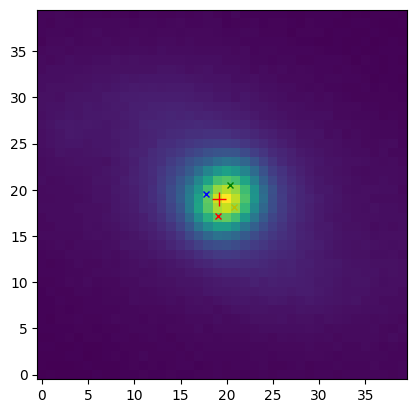

In [56]:
plt.figure()
plt.imshow(images40[0],    origin= 'lower') #cmap='gray', vmin=200, vmax=1000,
plt.plot(xgalaxy[0], ygalaxy[0], '+', ms=10,lw=2,mec='r')

plt.plot(xa[0], ya[0],'x',ms=5,mec='r')
plt.plot(xb[0], yb[0],'x',ms=5,mec='g')
plt.plot(xc[0], yc[0],'x',ms=5,mec='b')
plt.plot(xd[0], yd[0],'x',ms=5,mec='y')
#plt.plot(bx[0], by[0],'x',ms=5,mec='r')
# plt.plot(xgalaxy[0]-xa3[0], ygalaxy[0]-ya3[0],'x',ms=5,mec='r')
# plt.plot(xgalaxy[0]+xb3[0], ygalaxy[0]+yb3[0],'x',ms=5,mec='g')
# plt.plot(xgalaxy[0]-xc3[0], ygalaxy[0]+yc3[0],'x',ms=5,mec='b')
# plt.plot(xgalaxy[0]+xd3[0], ygalaxy[0]-yd3[0],'x',ms=5,mec='y')
    #plt.plot(xgalaxy[i], ygalaxy[i],'x',ms=5,mec='b')
    #plt.plot(xa[i], ya[i],'x',ms=5,mec='r')
    #plt.plot(xb[i], yb[i],'x',ms=5,mec='r')
    #plt.plot(xc[i], yc[i],'x',ms=5,mec='r')
    #plt.plot(xd[i], yd[i],'x',ms=5,mec='r')
print(np.sqrt((xa3)**2 + (ya3)**2))
print(np.sqrt((xb3)**2 + (yb3)**2))
print(np.sqrt((xc3)**2 + (yc3)**2))
print(np.sqrt((xd3)**2 + (ya3)**2))
l=np.array([np.mean([np.sqrt((xa3[i])**2 + (ya3[i])**2),np.sqrt((xb3[i])**2 + (yb3[i])**2),np.sqrt((xc3[i])**2 + (yc3[i])**2),np.sqrt((xd3[i])**2 + (ya3[i])**2)]) for i in range(0,4)])
print(l)
print('_____________________________') 
print('Distáncia R-G delplazado:',xgalaxy[0]-xa3[0] - (xgalaxy[0]+xb3[0]), ygalaxy[0]-ya3[0] -(ygalaxy[0]+yb3[0]))
print('Distáncia R-G:', xa[0]-xb[0],ya[0]-yb[0] )
print('Distáncia R-B delplazado:',xgalaxy[0]-xa3[0] - (xgalaxy[0]-xc3[0]), ygalaxy[0]-ya3[0] -(ygalaxy[0]+yc3[0]))
print('Distáncia R-B:', xa[0]-xc[0],ya[0]-yc[0] )
print('Distáncia R-Y delplazado:',xgalaxy[0]-xa3[0] - (xgalaxy[0]+xd3[0]), ygalaxy[0]-ya3[0] -(ygalaxy[0]-yd3[0]))
print('Distáncia R-Y:', xa[0]-xd[0],ya[0]-yd[0] )
print('_____________________________')
print('Distáncia G-B delplazado:',xgalaxy[0]+xb3[0] - (xgalaxy[0]-xc3[0]), ygalaxy[0]+yb3[0] -(ygalaxy[0]+yc3[0]))
print('Distáncia G-B:', xb[0]-xc[0],yb[0]-yc[0] )
print('Distáncia G-Y delplazado:',xgalaxy[0]+xb3[0] - (xgalaxy[0]+xd3[0]), ygalaxy[0]+yb3[0] -(ygalaxy[0]-yd3[0]))
print('Distáncia G-Y:', xb[0]-xd[0],yb[0]-yd[0] )
print('_____________________________')
print('Distáncia B-Y delplazado:',xgalaxy[0]-xc3[0] - (xgalaxy[0]+xd3[0]), ygalaxy[0]+yc3[0] -(ygalaxy[0]-yd3[0]))
print('Distáncia B-Y:', xc[0]-xd[0],yc[0]-yd[0] )



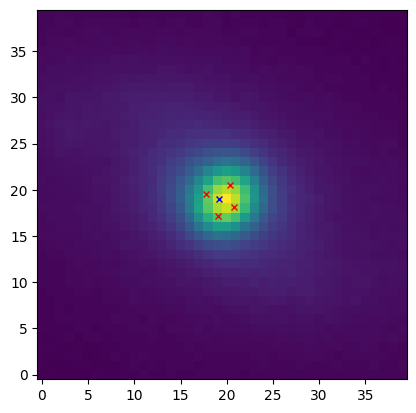

In [57]:
# Plot of the images and the positions of the components from the target
for i in range(Nep):
    plt.figure()
    plt.imshow(images40[i], origin= 'lower')
    plt.plot(xgalaxy[i], ygalaxy[i],'x',ms=5,mec='b')
    plt.plot(xa[i], ya[i],'x',ms=5,mec='r')
    plt.plot(xb[i], yb[i],'x',ms=5,mec='r')
    plt.plot(xc[i], yc[i],'x',ms=5,mec='r')
    plt.plot(xd[i], yd[i],'x',ms=5,mec='r')

In [58]:
output_folder = 'starred/EINSTEINCROSS/3.0'

for i in range(Nep):
    
    file_name = output_folder + '/epoch_' + str(i+1)
    

# Retrieving the PSF (must have one per epoch) 
psf_path = 'starred/EINSTEINCROSS/3.0'
narrow_PSF = []
for i in range(Nep):
    file_name = output_folder + '/epoch_' + str(i+1)
    file_paths = sorted(glob.glob(os.path.join(file_name, '*.fits')))
    s = np.array([fits.open(f) for f in file_paths])
    narrow_PSF.append(s[9][0].data)

narrow_PSF = np.array(narrow_PSF)
im_size_up = narrow_PSF.shape[1]
im_size = np.shape(images40)[1]
epochs = np.shape(images40)[0]

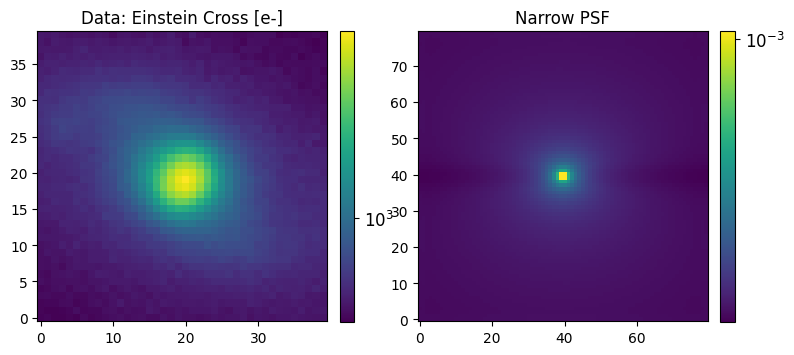

In [59]:
for i in range(Nep):
    fig, axs = plt.subplots(1, 2, figsize=(9,6))
    fraction = 0.046
    pad = 0.04

    plt.rc('font', size=12)           
    axs[0].set_title('Data: Einstein Cross [e-]', fontsize=12)
    axs[0].tick_params(axis='both', which='major', labelsize=10)
    axs[1].set_title('Narrow PSF', fontsize=12)
    axs[1].tick_params(axis='both', which='major', labelsize=10)

    fig.colorbar(axs[0].imshow(images40[i,...], norm=colors.SymLogNorm(linthresh=10), origin='lower'), ax=axs[0], fraction=fraction, pad=pad)
    fig.colorbar(axs[1].imshow(narrow_PSF[i,...], norm=colors.SymLogNorm(linthresh=1e-3), origin='lower'), ax=axs[1], fraction=fraction, pad=pad)
    plt.show()

In [60]:
# Noise map
sigma_2data = np.zeros((epochs, im_size, im_size))
sigma_sky_2data = np.array([np.std(images40[i,int(0.8*im_size):,int(0.8*im_size):]) for i in range(epochs)]) ** 2
for i in range(epochs):
    sigma_2data[i,:,:] = sigma_sky_2data[i] + images40[i,:,:].clip(min=0)

#normalise (to facilitate the job of the optimiser): 
norm = images40.max() / 100
data = images40 / norm
sigma_2data = sigma_2data / norm**2

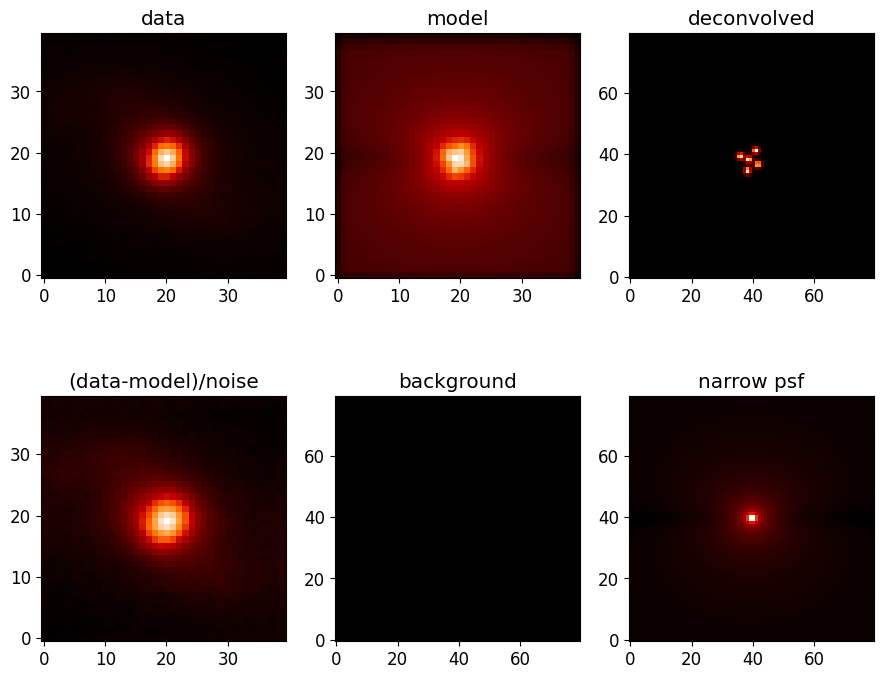

In [61]:
# positions of point sources, relative to center of image data.
        # print(x11,x21,x31,x41,y11,y21,y31,y41)
        # x11_=x11-742
        # y11_=y11-1213
        # x21_=x21-742
        # y21_=y21-1213
        # x31_=x31-742
        # y31_=y31-1213
        # x41_=x41-742
        # y41_=y41-1213
        # x51_=x51-742
        # y51_=y51-1213 
# xm=(x51_+x21_+x31_+x41_)/4
# ym=(Y51_+Y21_+Y31_+Y41_)/4
        # print(x11_,x21_,x31_,x51_,y11_,y21_,y31_,y51_,y41_,x41_)#
offset = (im_size-1)/2.
for i in range(Nep):
    # initial_c_x = np.array([xgalaxy[i], xgalaxy[i]-xa3[i],xgalaxy[i]+xb3[i],xgalaxy[i]-xc3[i],xgalaxy[i]+xd3[i]]) - offset 
    # initial_c_y = np.array([ygalaxy[i], ygalaxy[i]-ya3[i],ygalaxy[i]+yb3[i],ygalaxy[i]+yc3[i],ygalaxy[i]-yd3[i]]) - offset
    initial_c_x = np.array([xgalaxy[i], xa[i],xb[i],xc[i],xd[i]]) - offset 
    initial_c_y = np.array([ygalaxy[i],ya[i],yb[i],yc[i],yd[i]]) - offset
    # we give the inital amplitude for one epoch. The setup function
    # replicates them for all epochs. You can fine tune this later
    # if you feel like your amplitudes are widely different on an
    # epoch-per-epoch basis.
    pts_amp = [500,500] 
    initial_a = [pts_amp[j]  for i in range(epochs) for j in range(len(pts_amp))]
    model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(np.array([images40[i]]), 
                                                                           np.array([sigma_2data[i]]), 
                                                                           np.array([narrow_PSF[i]]), 
                                                                           initial_c_x,
                                                                           initial_c_y,
                                                                           subsampling_factor,
                                                                           initial_a=None)

    # print(np.shape(model), np.shape(kwargs_init), np.shape(images40[0]), np.shape(sigma_2data[0]))
    # plt.figure()
    # plt.imshow(model.model(kwargs_init)[0])
    # plt.figure()
    # plt.imshow(model2, norm=colors.SymLogNorm(linthresh=1e-3), origin='lower')
    # we can use this to inspect our inital conditions, are they reasonable?
    view_deconv_model(model, kwargs_init, np.array([images40[i]]), np.array([sigma_2data[i]]))
    # yep they are reasonable, our point sources fall more or less
    # in the correct positions, and their amplitudes more or less
    # cancel those of the data.